In [4]:
import pandas as pd

import seaborn as sns

sns.set_context("talk")
import matplotlib.pyplot as plt
import statsmodels

import statsmodels.formula.api as smf
import numpy as np

plt.style.use("ggplot")

In [5]:
data=pd.read_csv('clean_data/final_dataset.csv')
data[['income_census','pop_census']]=np.log(data[['income_census','pop_census']])

In [6]:
data.columns
y = "mortality_self_ha"
x = [
    "pop_census",
    "nhwrate",
    "blkrate",
    "asianrate",
    "hisprate",
    "nativerate",
    "state_mormon",
    "altitude",
    "mormon",
    "income_census"
]

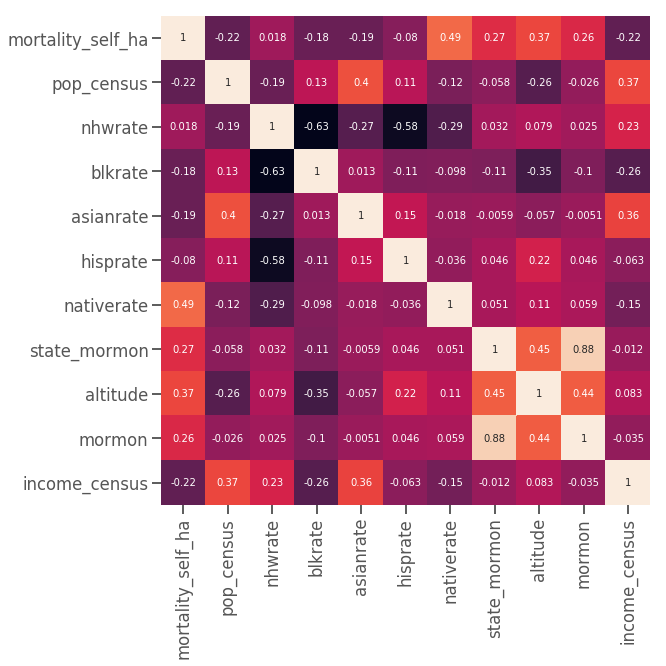

In [7]:
plt.figure(figsize=(9,9))
sns.heatmap(data[[y]+x].corr(),annot=True,square=True,cbar=False)

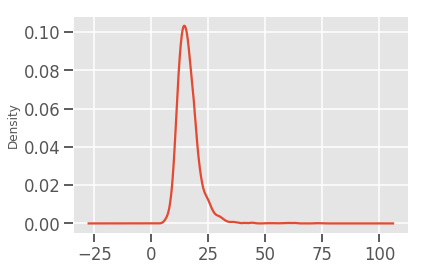

In [8]:
#lognormal
data['mortality_self_ha'].plot.kde()

In [9]:
data.mortality_self_ha.describe()

count    3126.000000
mean       16.213209
std         5.024903
min         5.910000
25%        13.065000
50%        15.470000
75%        18.330000
max        72.590000
Name: mortality_self_ha, dtype: float64

In [10]:
import statsmodels.api as sm


def regress(
    x,
    y,
    model="ols",
    plot=False,
    summary=False,
    show_nonsignificant=False,
    data=data,
    log=False,
):
    # Weighted regression due to different pop size in each county. Lower pops will be noisier.
    if log:
        expr = f"np.log({y})~" + "+".join(x)
        logiflog = np.log
    else:
        expr = f"({y})~" + "+".join(x)
        logiflog = lambda x: x
    if model == "glm":
        ret = smf.glm(
            expr,
            data=data,
            family=sm.families.Gaussian(link=sm.families.links.log()),
            var_weights=data.pop_census,
        ).fit()
    elif model == "wls":
        ret = smf.ols(expr, data=data).fit()
    else:
        ret = smf.wls(expr, data=data, weights=data["pop_census"]).fit()
    if summary:
        display(ret.summary())
    if plot:
        if model == "glm":
            pred = logiflog(ret.predict(data[x]).squeeze())
        else:
            pred = logiflog(ret.predict(data[x]).squeeze())
        display(plt.scatter(data[y], pred))
        max_y = max(data[y])
        min_y = min(data[y])
        plt.plot([min_y, max_y], [min_y, max_y], c="blue")
    df = pd.concat([ret.params, ret.pvalues], axis=1)

    df.columns = ["coefficients", "pvalue"]
    df["pvalue"] = df["pvalue"].round(3)
    df["pvalue"] = np.where(
        df.pvalue < 0.05, df.pvalue.astype(str) + "*", df.pvalue.astype(str)
    )
    if not show_nonsignificant:
        df = df[df.pvalue.str.contains("\*")]

    mean_frame = data[x].mean().to_frame().T
    if 'state' in x:
        mean_frame['state']='Utah'
    mean_predicted = ret.predict(mean_frame).values
    display(f"Baseline value: {np.round(mean_predicted,2).squeeze()}")

    for var in df.index:
        if var != "Intercept" and "state[" not in var:
            df.loc[var, "var_max_value"] = data[var].max()
            df.loc[var, "var_mean_value"] = data[var].mean()
            df.loc[var, "effect_mean_to_max"] = (
                ret.predict(mean_frame.assign(**{var: data[var].max()})).values
                - mean_predicted
            )
    # df["effect_pc"] = 100 * (df.effect_mean_to_max) / mean_predicted
    df = df.round(3)

    return df, ret


t, mod = regress(x, y, model="glm", log=False)
t

'Baseline value: 15.98'

,coefficients,pvalue,var_max_value,var_mean_value,effect_mean_to_max
Intercept,7.506,0.0*,NaN,NaN,NaN
nhwrate,-2.426,0.0*,1.000,0.788,-6.419
blkrate,-2.638,0.0*,0.861,0.089,-13.902
asianrate,-4.921,0.0*,0.522,0.011,-14.691
hisprate,-2.737,0.0*,0.983,0.078,-14.641
nativerate,-1.490,0.0*,0.889,0.017,-11.621
state_mormon,0.398,0.0*,0.690,0.022,4.857
altitude,0.000,0.0*,4008.285,424.280,12.507
income_census,-0.241,0.0*,11.073,9.996,-3.648


In [11]:
# #Keep state as per BIC and AIC
# df,mod=regress(x,y2,model='glm')
# df
# #???? (weird numerical error)

In [12]:
df,mod=regress(x,y,model='ols',)
df

'Baseline value: 16.22'

,coefficients,pvalue,var_max_value,var_mean_value,effect_mean_to_max
Intercept,98.181,0.0*,NaN,NaN,NaN
pop_census,0.146,0.011*,16.078,10.225,0.857
nhwrate,-38.364,0.0*,1.000,0.788,-8.119
blkrate,-41.537,0.0*,0.861,0.089,-32.094
asianrate,-64.545,0.0*,0.522,0.011,-32.988
hisprate,-44.099,0.0*,0.983,0.078,-39.916
nativerate,-12.841,0.004*,0.889,0.017,-11.193
state_mormon,9.660,0.0*,0.690,0.022,6.447
altitude,0.003,0.0*,4008.285,424.280,10.692
income_census,-4.660,0.0*,11.073,9.996,-5.019


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      mortality_self_ha   R-squared:                       0.440
Model:                            OLS   Adj. R-squared:                  0.438
Method:                 Least Squares   F-statistic:                     244.8
Date:                Mon, 31 Dec 2018   Prob (F-statistic):               0.00
Time:                        16:47:32   Log-Likelihood:                -8575.2
No. Observations:                3126   AIC:                         1.717e+04
Df Residuals:                    3115   BIC:                         1.724e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        98.4808      5.337     18.452      0.000      88.016     108.945
pop_census        0.1782      0.058      3.095      0.002       0.065       0.291
nhwrate         -39.4888      4.091     -9.654      0.000     -47.509     -31.468
blkrate         -42.6349      4.071    -10.473      0.000     -50.617     -34.653
asianrate       -66.5693      5.971    -11.149      0.000     -78.277     -54.862
hisprate        -45.0984      4.083    -11.046      0.000     -53.103     -37.094
nativerate      -13.2530      4.490     -2.952      0.003     -22.057      -4.449
state_mormon      8.8746      1.990      4.460      0.000       4.973      12.776
altitude          0.0030      0.000     17.000      0.000       0.003       0.003
mormon           -0.0010      0.002     -0.591      0.555      -0.004       0.002
income_census    -4.6150      0.382    -12.094      0.000      -5.363      -3.867
==============================================================================
Omnibus:                     1217.764   Durbin-Watson:                   1.525
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            16510.043
Skew:                           1.467   Prob(JB):                         0.00
Kurtosis:                      13.870   Cond. No.                     1.04e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.04e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

'Baseline value: 16.21'

,coefficients,pvalue,var_max_value,var_mean_value,effect_mean_to_max
Intercept,98.481,0.0*,NaN,NaN,NaN
pop_census,0.178,0.002*,16.078,10.225,1.043
nhwrate,-39.489,0.0*,1.000,0.788,-8.357
blkrate,-42.635,0.0*,0.861,0.089,-32.943
asianrate,-66.569,0.0*,0.522,0.011,-34.022
hisprate,-45.098,0.0*,0.983,0.078,-40.821
nativerate,-13.253,0.003*,0.889,0.017,-11.553
state_mormon,8.875,0.0*,0.690,0.022,5.923
altitude,0.003,0.0*,4008.285,424.280,10.757
income_census,-4.615,0.0*,11.073,9.996,-4.970


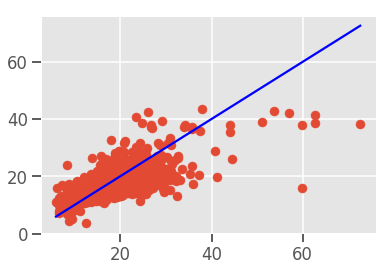

In [13]:
#Not much difference from plain OLS
df,mod=regress(x,y,model='wls',plot=True,summary=True)
df

In [14]:
target = data.query('county=="Salt Lake"')[x]
no_mormons = target.assign(mormon=0)
pd.Series(
    {
        "predicted": mod.predict(target).values[0],
        "baseline": data[y].iloc[target.index].values[0],
        "no_mormons": mod.predict(no_mormons).values[0],
        "no_mormons-predicted": mod.predict(no_mormons).values[0] - mod.predict(target).values[0],
    }
)

predicted               23.961040
baseline                25.390000
no_mormons              24.550481
no_mormons-predicted     0.589440
dtype: float64

# Effect of mormon
After controlling for income, the effect of mormonism is similar to the effect of everything else: tiny. Full mormonisation would yield negligible gains.

But what if? Mormon->Income?

'Baseline value: 10.0'

,coefficients,pvalue,var_max_value,var_mean_value,effect_mean_to_max
Intercept,9.767,0.0*,NaN,NaN,NaN
mormon,-0.000,0.002*,1007.860,21.801,-0.127
nhwrate,0.275,0.0*,1.000,0.788,0.058
blkrate,-0.168,0.0*,0.861,0.089,-0.130
asianrate,3.753,0.0*,0.522,0.011,1.918
nativerate,-0.278,0.0*,0.889,0.017,-0.242


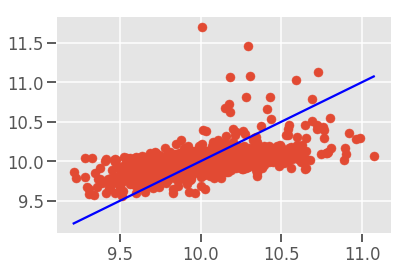

In [15]:
df, mod = regress(
    ["mormon", "nhwrate", "blkrate", "asianrate", "nativerate"],
    "income_census",
    plot=True,
)
df

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      mortality_self_ha   R-squared:                       0.440
Model:                            OLS   Adj. R-squared:                  0.438
Method:                 Least Squares   F-statistic:                     244.8
Date:                Mon, 31 Dec 2018   Prob (F-statistic):               0.00
Time:                        16:47:33   Log-Likelihood:                -8575.2
No. Observations:                3126   AIC:                         1.717e+04
Df Residuals:                    3115   BIC:                         1.724e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        98.4808      5.337     18.452      0.000      88.016     108.945
pop_census        0.1782      0.058      3.095      0.002       0.065       0.291
nhwrate         -39.4888      4.091     -9.654      0.000     -47.509     -31.468
blkrate         -42.6349      4.071    -10.473      0.000     -50.617     -34.653
asianrate       -66.5693      5.971    -11.149      0.000     -78.277     -54.862
hisprate        -45.0984      4.083    -11.046      0.000     -53.103     -37.094
nativerate      -13.2530      4.490     -2.952      0.003     -22.057      -4.449
state_mormon      8.8746      1.990      4.460      0.000       4.973      12.776
altitude          0.0030      0.000     17.000      0.000       0.003       0.003
mormon           -0.0010      0.002     -0.591      0.555      -0.004       0.002
income_census    -4.6150      0.382    -12.094      0.000      -5.363      -3.867
==============================================================================
Omnibus:                     1217.764   Durbin-Watson:                   1.525
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            16510.043
Skew:                           1.467   Prob(JB):                         0.00
Kurtosis:                      13.870   Cond. No.                     1.04e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.04e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

'Baseline value: 16.21'

,coefficients,pvalue,var_max_value,var_mean_value,effect_mean_to_max
Intercept,98.481,0.0*,NaN,NaN,NaN
pop_census,0.178,0.002*,16.078,10.225,1.043
nhwrate,-39.489,0.0*,1.000,0.788,-8.357
blkrate,-42.635,0.0*,0.861,0.089,-32.943
asianrate,-66.569,0.0*,0.522,0.011,-34.022
hisprate,-45.098,0.0*,0.983,0.078,-40.821
nativerate,-13.253,0.003*,0.889,0.017,-11.553
state_mormon,8.875,0.0*,0.690,0.022,5.923
altitude,0.003,0.0*,4008.285,424.280,10.757
income_census,-4.615,0.0*,11.073,9.996,-4.970


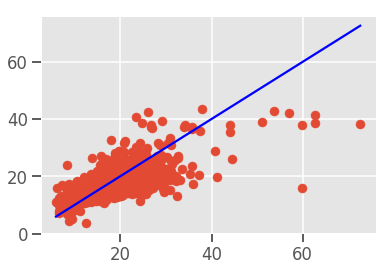

In [16]:
x2=x+['state']
#Keep state as per BIC and AIC
df,mod=regress(x,y,model='wls',plot=True,summary=True)
df

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      mortality_self_ha   R-squared:                       0.620
Model:                            OLS   Adj. R-squared:                  0.613
Method:                 Least Squares   F-statistic:                     84.94
Date:                Mon, 31 Dec 2018   Prob (F-statistic):               0.00
Time:                        16:47:33   Log-Likelihood:                -7967.7
No. Observations:                3126   AIC:                         1.606e+04
Df Residuals:                    3066   BIC:                         1.642e+04
Df Model:                          59                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                        74.9157      6.189     12.105      0.000      62.781      87.051
state[T.Alaska]                   8.0436      0.901      8.927      0.000       6.277       9.810
state[T.Arizona]                  1.5346      0.944      1.625      0.104      -0.317       3.386
state[T.Arkansas]                 0.9375      0.531      1.765      0.078      -0.104       1.979
state[T.California]               1.6025      0.627      2.558      0.011       0.374       2.831
state[T.Colorado]                 1.5956      0.705      2.263      0.024       0.213       2.978
state[T.Connecticut]             -4.0543      1.188     -3.411      0.001      -6.385      -1.724
state[T.Delaware]                -0.8617      1.849     -0.466      0.641      -4.487       2.764
state[T.District of Columbia]    -1.0128      3.165     -0.320      0.749      -7.219       5.193
state[T.Florida]                  1.0303      0.552      1.865      0.062      -0.053       2.113
state[T.Georgia]                 -1.5215      0.456     -3.334      0.001      -2.416      -0.627
state[T.Hawaii]                   6.1082      2.313      2.641      0.008       1.574      10.643
state[T.Idaho]                    0.2825      0.649      0.435      0.664      -0.991       1.556
state[T.Illinois]                -4.3167      0.513     -8.417      0.000      -5.322      -3.311
state[T.Indiana]                 -2.4272      0.527     -4.605      0.000      -3.461      -1.394
state[T.Iowa]                    -5.0445      0.521     -9.687      0.000      -6.066      -4.023
state[T.Kansas]                  -2.6814      0.521     -5.144      0.000      -3.703      -1.659
state[T.Kentucky]                -1.4132      0.499     -2.831      0.005      -2.392      -0.434
state[T.Louisiana]               -1.5803      0.548     -2.885      0.004      -2.654      -0.506
state[T.Maine]                   -3.1935      0.885     -3.609      0.000      -4.928      -1.459
state[T.Maryland]                 2.7251      0.758      3.593      0.000       1.238       4.212
state[T.Massachusetts]           -3.4924      0.942     -3.708      0.000      -5.339      -1.646
state[T.Michigan]                -2.8278      0.534     -5.299      0.000      -3.874      -1.781
state[T.Minnesota]               -5.1543      0.535     -9.634      0.000      -6.203      -4.105
state[T.Mississippi]             -1.1664      0.521     -2.239      0.025      -2.188      -0.145
state[T.Missouri]                -2.0276      0.502     -4.042      0.000      -3.011      -1.044
state[T.Montana]                  0.5737      0.613      0.936      0.350      -0.629       1.776
state[T.Nebraska]                -5.3530      0.537     -9.973      0.000      -6.405      -4.301
state[T.Nevada]                  10.0088     

'Baseline value: 20.22'

,coefficients,pvalue,var_max_value,var_mean_value,effect_mean_to_max
Intercept,74.916,0.0*,NaN,NaN,NaN
state[T.Alaska],8.044,0.0*,NaN,NaN,NaN
state[T.California],1.603,0.011*,NaN,NaN,NaN
state[T.Colorado],1.596,0.024*,NaN,NaN,NaN
state[T.Connecticut],-4.054,0.001*,NaN,NaN,NaN
state[T.Georgia],-1.521,0.001*,NaN,NaN,NaN
state[T.Hawaii],6.108,0.008*,NaN,NaN,NaN
state[T.Illinois],-4.317,0.0*,NaN,NaN,NaN
state[T.Indiana],-2.427,0.0*,NaN,NaN,NaN
state[T.Iowa],-5.045,0.0*,NaN,NaN,NaN


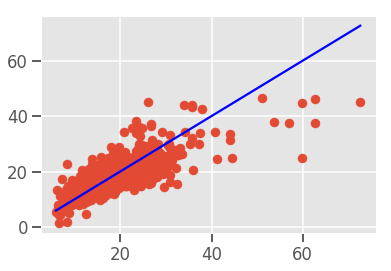

In [17]:
df,mod=regress(x2,y,model='wls',plot=True,summary=True)
df

In [18]:
target = data.query('county=="Salt Lake"')[x2]
no_mormons = target.assign(mormon=0)
pd.Series(
    {
        "predicted": mod.predict(target).values[0],
        "baseline": data[y].iloc[target.index].values[0],
        "no_mormons": mod.predict(no_mormons).values[0],
        "no_mormons-predicted": mod.predict(no_mormons).values[0] - mod.predict(target).values[0],
    }
)

predicted               22.662809
baseline                25.390000
no_mormons              23.481455
no_mormons-predicted     0.818646
dtype: float64

Final prediction from linear models: Full 1000->0 demormonisation would lead to a rise in the suicide rate of 0.81pp.

# Let's try catboost

In [19]:
from skopt import BayesSearchCV
from sklearn.model_selection import KFold,StratifiedKFold
from lightgbm import LGBMRegressor,Dataset
from lightgbm import plot_importance

ITERATIONS=100
def get_bayes_tuner(cat_feat=[]):
    search_space = {
 
        "num_leaves":(10,40),
        "min_child_samples":(5,50),
        "learning_rate":(0.01,0.5,"uniform"),
        "n_estimators":(10,500),
        "min_split_gain":(0.,1.,"uniform"),
        "colsample_bytree":(0.5,0.8,1)

    }
    return BayesSearchCV(
        estimator=LGBMRegressor(n_jobs=6),
        search_spaces=search_space,
        cv=KFold(n_splits=20, shuffle=True, random_state=42),
        n_jobs=2,
        n_iter=ITERATIONS,
        verbose=3,
        refit=True,
        random_state=42,
        scoring="r2",
        fit_params={'categorical_feature':cat_feat}
    )

In [20]:
data['state_factor'],factor_array=pd.factorize(data.state)

In [21]:
x3=x2[::1]
x3.remove('state')
x3.append('state_factor')
x3.append('income_census')

In [22]:
cat_pos = np.where(data[x3].dtypes == int)[0].tolist()

bayes_tuner = get_bayes_tuner(cat_pos)
cat = bayes_tuner.fit(data[x3], data[y])

Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    1.8s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.9s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Done  10 out of  20 | elapsed:    0.6s remaining:    0.6s
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.8s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    1.5s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    1.5s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.9s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Done  10 out of  20 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.7s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  20 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.6s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.9s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.9s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.3s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    6.3s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    5.8s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    6.1s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    5.4s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    6.9s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    6.4s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    2.1s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    6.1s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    5.9s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    2.2s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    4.0s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    2.9s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    5.2s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    2.9s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    4.2s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    1.1s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    1.8s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    1.9s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    2.0s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    5.6s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  20 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.7s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    5.4s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  20 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    0.7s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    1.2s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    3.3s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    1.0s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    1.0s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    5.0s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    5.7s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    7.8s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    6.8s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    1.7s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    6.9s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    3.9s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    3.8s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    3.9s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    1.4s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    6.2s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    1.4s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    6.0s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    2.0s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    5.9s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    1.5s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    4.9s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    5.5s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    5.7s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    6.6s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    6.4s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    8.2s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    5.9s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    5.9s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    5.8s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    5.2s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    7.5s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    7.0s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    5.6s finished
/home/jose/envs/env/lib/python3.6/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    6.7s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    5.9s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    5.8s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    9.4s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    8.2s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    7.9s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    9.1s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    6.1s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:   10.6s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    2.8s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:  1.4min finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:  3.1min finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:  1.7min finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:  2.3min finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:   22.9s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:   24.0s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:   13.5s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:  1.3min finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:   13.4s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:  1.6min finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:   13.8s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:   36.3s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:   43.0s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:  2.9min finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:  3.8min finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:  1.0min finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   3 out of  20 | elapsed:    0.3s remaining:    1.6s
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    1.7s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:  1.1min finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:  1.1min finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:   59.8s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:  1.4min finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:   33.5s finished


Fitting 20 folds for each of 1 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:  1.4min finished


In [23]:
pd.DataFrame(cat.cv_results_).sort_values('mean_test_score',ascending=False)

,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,...,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_learning_rate,param_min_child_samples,param_min_split_gain,param_n_estimators,param_num_leaves,params
11,0.526405,0.692481,0.640809,0.453540,0.595257,0.686120,0.661245,0.592289,0.496510,0.794900,...,0.094463,0.006322,0.003152,0.8,0.010000,5,1.000000,500,40,"{'colsample_bytree': 0.8, 'learning_rate': 0.0..."
19,0.526405,0.692481,0.640809,0.453540,0.595257,0.686120,0.661245,0.592289,0.496510,0.794900,...,0.021242,0.005462,0.000583,0.8,0.010000,5,1.000000,500,40,"{'colsample_bytree': 0.8, 'learning_rate': 0.0..."
18,0.526405,0.692481,0.640809,0.453540,0.595257,0.686120,0.661245,0.592289,0.496510,0.794900,...,0.039489,0.005393,0.000347,0.8,0.010000,5,1.000000,500,40,"{'colsample_bytree': 0.8, 'learning_rate': 0.0..."
16,0.527511,0.690625,0.638880,0.447743,0.594646,0.685778,0.658905,0.589701,0.499253,0.796958,...,0.085968,0.006232,0.003928,0.8,0.010000,5,0.000000,500,40,"{'colsample_bytree': 0.8, 'learning_rate': 0.0..."
13,0.527511,0.690625,0.638880,0.447743,0.594646,0.685778,0.658905,0.589701,0.499253,0.796958,...,0.070103,0.005665,0.000816,0.8,0.010000,5,0.000000,500,40,"{'colsample_bytree': 0.8, 'learning_rate': 0.0..."
12,0.527511,0.690625,0.638880,0.447743,0.594646,0.685778,0.658905,0.589701,0.499253,0.796958,...,0.024921,0.005275,0.000576,0.8,0.010000,5,0.000000,500,40,"{'colsample_bytree': 0.8, 'learning_rate': 0.0..."
15,0.527511,0.690609,0.638880,0.447743,0.594646,0.685778,0.658905,0.589701,0.499253,0.796958,...,0.118605,0.006684,0.003522,0.8,0.010000,5,0.026260,500,40,"{'colsample_bytree': 0.8, 'learning_rate': 0.0..."
23,0.503438,0.620809,0.646108,0.646606,0.612697,0.681620,0.614373,0.649080,0.477228,0.658820,...,0.025949,0.005882,0.000602,0.8,0.010000,27,1.000000,500,40,"{'colsample_bytree': 0.8, 'learning_rate': 0.0..."
74,0.519099,0.690185,0.639024,0.458898,0.592570,0.682357,0.660418,0.593672,0.496603,0.793483,...,0.064665,0.005717,0.001578,0.8,0.010000,5,1.000000,452,40,"{'colsample_bytree': 0.8, 'learning_rate': 0.0..."
62,0.517992,0.689850,0.638556,0.459680,0.592000,0.682102,0.660344,0.593940,0.496591,0.793260,...,0.069852,0.006140,0.002053,0.8,0.010000,5,1.000000,449,40,"{'colsample_bytree': 0.8, 'learning_rate': 0.0..."


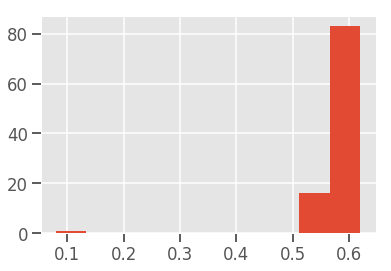

In [24]:
pd.DataFrame(cat.cv_results_).sort_values('mean_test_score').mean_test_score.hist()

Catboost is a nonlinear model, so we lose explainability. Feature importances in tree models are commonly used to try to interpret them, but those may be biased by multicollinearity. Let's try to see what we get from them first:

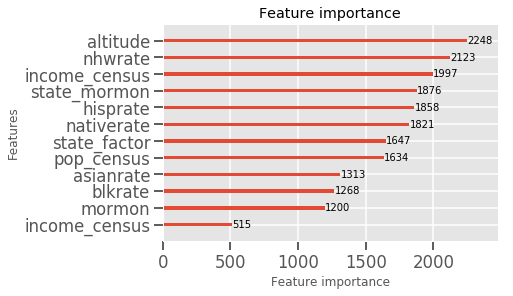

In [25]:
plot_importance(cat.best_estimator_)

Again, mormon comes as relatively not important

### Explanation with SHAP

These feature importances may be fake news because of multicollinearity issues, so we turn to SHAP to see what features drive this model.

[SHAP](https://arxiv.org/pdf/1705.07874.pdf) produces a score for each pair of (feature,sample), indicating how much that feature contributed in that particular case. In effect SHAP is solving a credit assignment problem.

Unlike with the coefficients in OLS, here we have scores per pair of features, which make it more important to visualise what is going on on a case by case basis to see if trends emerge

In [26]:
import shap
shap.initjs()


In [27]:
explainer=shap.TreeExplainer(cat.best_estimator_)
shaps=explainer.shap_values(data[x３])

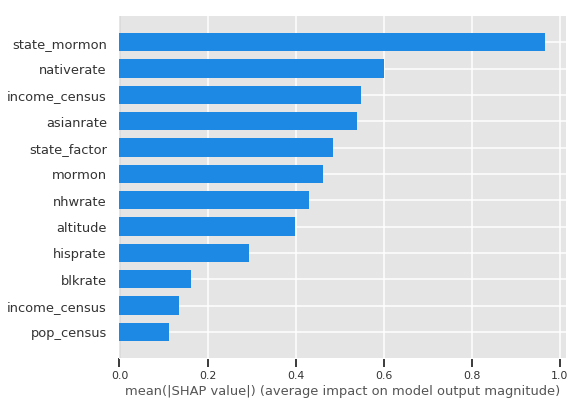

In [28]:
shap.summary_plot(shaps,data[x3], plot_type="bar")

Also in CatBoost, mormons are not a significant variable

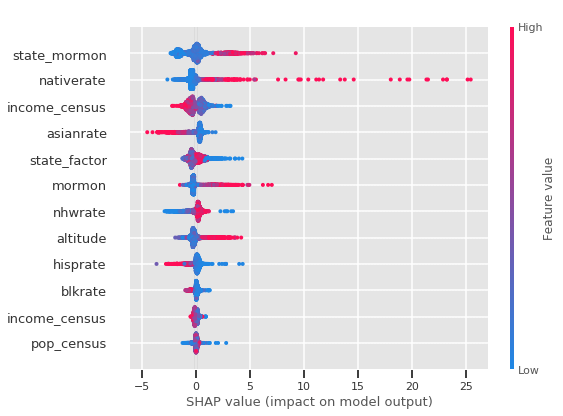

In [29]:
# This plot measures the impact of a variable on poverty. Each point is a particular county.
# The y-size of each row represents the density of points at that particular point
# High SHAP values mean in that case the variable in that case contributed to a higher poverty rate
# The sense in which it contributed can be glanced from the colorbar
# For example, the blue points in income_census mean that when income was low, the SHAP value was high (higher poverty)
# Positive values mean that in that part
shap.summary_plot(shaps,data[x3])

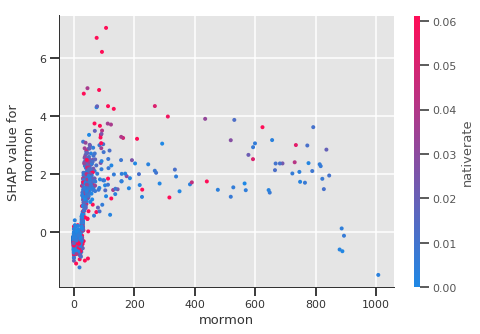

In [30]:
shap.dependence_plot("mormon", shaps,data[x3])

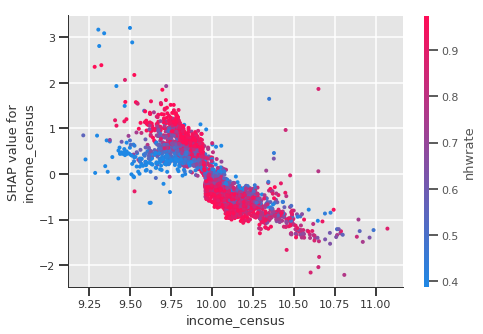

In [31]:
shap.dependence_plot("income_census", shaps,data[x3])

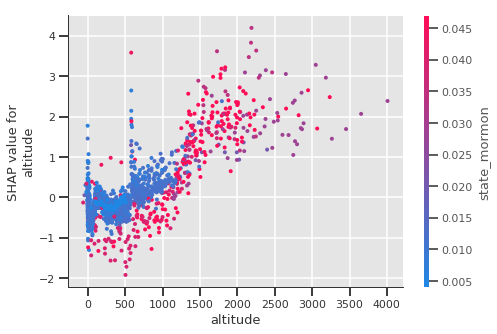

In [40]:
shap.dependence_plot("altitude", shaps,data[x3])

In [32]:
#Salt Lake
shap.force_plot(explainer.expected_value,shaps[2778,:],data[x3].loc[2778,:])

In [33]:
shap.force_plot(explainer.expected_value,shaps[217,:],data[x3].loc[217,:])

In [34]:
data.query('county=="San Francisco"')

,state,county,povrate,pop_census,income_census,nhwrate,blkrate,asianrate,nativerate,hisprate,...,pov_saipe_2017,mortality_alcohol,mortality_drug_us,mortality_self_ha,mortality_interpe,mortality,outcomes,state_mormon,altitude,state_factor
217,California,San Francisco,0.118615,13.567917,10.724984,0.420773,0.060655,0.333613,0.002651,0.147085,...,0.101,7.41,19.12,12.43,6.54,0.234244,0.228563,0.020478,15.562419,4


In [35]:
target = data.query('county=="Salt Lake"')[x3]
no_mormons = target.assign(mormon=0)
pd.Series(
    {
        "predicted": cat.predict(target)[0],
        "baseline": data[y].iloc[target.index].values[0],
        "no_mormons": cat.predict(no_mormons)[0],
         "diff":-cat.predict(target)[0]+cat.predict(no_mormons)[0]
    }
)

predicted     24.079595
baseline      25.390000
no_mormons    19.503523
diff          -4.576071
dtype: float64

Demormonisation would reduce suicide-related deaths by 4.57 pp. But there is some difference between the baseline (real) and predicted values.

In [36]:
#The effect is also there for more mormons
target = data.query('county=="Salt Lake"')[x3]
no_mormons = target.assign(mormon=1000)
pd.Series(
    {
        "predicted": cat.predict(target)[0],
        "baseline": data[y].iloc[target.index].values[0],
        "no_mormons": cat.predict(no_mormons)[0],
         "diff":-cat.predict(target)[0]+cat.predict(no_mormons)[0]
    }
)

predicted     24.079595
baseline      25.390000
no_mormons    19.921922
diff          -4.157673
dtype: float64

What would happen if SLC had a substantial native population?

In [37]:
target = data.query('county=="Salt Lake"')[x3]
counterfactual = target.assign(nhwrate=0,hisprate=0,blkrate=0,nativerate=1,asianrate=0)
pd.Series(
    {
        "predicted": cat.predict(target)[0],
        "baseline": data[y].iloc[target.index].values[0],
        "counterf": cat.predict(counterfactual)[0],
         "diff":-cat.predict(target)[0]+cat.predict(counterfactual)[0]
    }
)

predicted    24.079595
baseline     25.390000
counterf     52.577946
diff         28.498351
dtype: float64

In that case suicides would increase by far more.

In [38]:
#What about altitude?

In [39]:
target = data.query('county=="Salt Lake"')[x3]
counterfactual = target.assign(altitude=0)
pd.Series(
    {
        "predicted": cat.predict(target)[0],
        "baseline": data[y].iloc[target.index].values[0],
        "counterf": cat.predict(counterfactual)[0],
         "diff":-cat.predict(target)[0]+cat.predict(counterfactual)[0]
    }
)
#Altitude would reduce suicide a bit more than demormonisation

predicted    24.079595
baseline     25.390000
counterf     18.174083
diff         -5.905512
dtype: float64